### Ryan's Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
import sklearn.neural_network
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function

%matplotlib inline

/Users/ryankerr/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [7]:
%%time 
"""
Read in train/validate and test as Pandas DataFrames
"""
df_train = pd.read_csv("train")
df_test = pd.read_csv("test")
df_features = pd.DataFrame.from_csv("array_touse.csv", index_col=None, header=None)

CPU times: user 2min 27s, sys: 17.6 s, total: 2min 45s
Wall time: 2min 53s


In [8]:
df_train.shape, df_test.shape, df_features.shape

((1000000, 258), (824230, 258), (1824230, 264))

In [6]:
df_train.head()

,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,...,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256,gap
0,c1ccc(o1)-c1ccc(s1)-c1cnc(-c2scc3[se]ccc23)c2n...,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1.19
1,C1=CC=C(C1)c1cc2ncc3c4[SiH2]C=Cc4ncc3c2c2=C[Si...,1,0,0,0,1,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1.60
2,[nH]1c-2c([SiH2]c3cc(-c4scc5C=CCc45)c4nsnc4c-2...,1,0,0,0,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1.49
3,[nH]1c2-c3occc3Cc2c2c1cc(-c1cccc3=C[SiH2]C=c13...,1,0,0,0,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1.36
4,c1cnc2c3oc4cc(-c5ncncn5)c5nsnc5c4c3c3cocc3c2c1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1.98


In [9]:
df_test.head()

,Id,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,...,feat_247,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256
0,1,c1sc(-c2cnc3c(c2)c2nsnc2c2cc4cccnc4cc32)c2cc[n...,0,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
1,2,[nH]1cccc1-c1cc2c3nsnc3c3c4sccc4[nH]c3c2s1,0,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
2,3,[nH]1c2cc(-c3ccc[se]3)c3nsnc3c2c2c3cscc3c3ccc4...,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
3,4,[nH]1c(cc2cnc3c(c12)c1=C[SiH2]C=c1c1ccc2=CCC=c...,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
4,5,c1sc(-c2sc(-c3sc(-c4scc5[se]ccc45)c4ccoc34)c3c...,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [19]:
#create temporary dataset (subsample of training)
df_temp = df_train.sample(frac=0.05)
Y_temp = df_temp.gap.values 
df_temp = df_temp.drop(['gap'],axis=1).reset_index(drop=True)

## Training-validation split
Having done feature engineering, we split the training data into a training (30%) and validation (70%) set:

__@Max - I think we should be doing something like 60% train, 20% validate and 20% test__ : http://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio

In [18]:
Y = df_train.gap

In [24]:
df_feat_train     = df_features.ix[:999999, ]
df_feat_supertest = df_features.ix[1000000:, ].values

# mask for our testing data
train_mask = np.genfromtxt('val_train_split.csv', delimiter=",")
train_mask = [bool(x) for x in train_mask]
test_mask  = [not x for x in train_mask]

df_feat_test  = df_feat_train[test_mask]
df_feat_train = df_feat_train[train_mask]

Y_train = Y[train_mask].values
Y_test  = Y[test_mask].values

df_feat_train.shape, df_feat_test.shape, df_feat_supertest.shape, Y_train.shape

((800787, 264), (199213, 264), (824230, 264), (800787,))

In [29]:
def split_df(df, ys, ps):
    """
    df: unaltered (smiles included) pd dataframe
    ys: unaltered yvalues array
    ps: """
    try:
        df = df.drop(["smiles"], axis=1)
    except:
        pass
    try:
        df = df.drop(["molecule"], axis=1)
    except:
        pass
    splits = np.random.choice([0,1,2], size=(len(df)), p=ps)
    df["group"] = splits
    x_train    = df[df["group"] == 0].drop(['group'], axis=1)
    x_validate = df[df["group"] == 1].drop(['group'], axis=1)
    x_test     = df[df["group"] == 2].drop(['group'], axis=1)
    y_train    = [ys[i] for i in range(len(ys)) if splits[i] == 0]
    y_validate = [ys[i] for i in range(len(ys)) if splits[i] == 1]
    y_test     = [ys[i] for i in range(len(ys)) if splits[i] == 2]
    
    return x_train.values, x_validate.values, x_test.values, y_train, y_validate, y_test

In [30]:
X_train, X_validate, _, Y_train, Y_validate, _ = split_df(df_feat_train, Y_train, [.75, .25, 0.0])

In [31]:
X_train.shape, X_validate.shape, len(Y_train), len(Y_validate)

((601066, 264), (199721, 264), 601066, 199721)

## Computing RMSE
The sklearn function below computes RMSE, which is the loss function we are minimizing in this practical.

In [23]:
#Create dictionary of RMSEs
try:
    RMSE_dict
except:
    RMSE_dict = {}

In [ ]:
%%time 
LR = LinearRegression()
LR.fit(X_train, Y_train)
#check RMSE on validation set 
LR_val_pred = LR.predict(X_validate)
LR_MSE = mean_squared_error(Y_validate, LR_val_pred)

##LR_pred = LR.predict(X_test)
RMSE_dict['LR_nofeat']=LR_MSE
print(LR_MSE)

### Random Forest Regression

In [35]:
def rf_regress(X_train, Y_train, X_validate, Y_validate,
               n_estimators=10, max_features="auto", bootstrap="true"):
    RF = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, bootstrap=bootstrap)
    RF.fit(X_train, Y_train)
    RF_val_pred   = RF.predict(X_validate)
    RF_train_pred = RF.predict(X_train)
    RF_MSE = mean_squared_error(Y_validate,RF_val_pred)
    RF_MSE_train = mean_squared_error(Y_train, RF_train_pred)
    ##RF_pred = RF.predict(X_test)
#     try:
#         RMSE_dict[name].append((RF_MSE, n_estimators, max_features, bootstrap))
#     except:
#         RMSE_dict[name] = [(RF_MSE, n_estimators, max_features, bootstrap)]
    
#     RMSE_dict[name] = (RF_MSE, n_estimators, max_features, bootstrap)
    return RF_MSE_train, RF_MSE, RF
    

Time to try this on our big dataset and make an actual prediction. This model is relativly short to run, so I decide not to pickle it. Instead I just save the prediction.

In [36]:
%%time
a, b, RF_model = rf_regress(X_train, Y_train, X_validate, Y_validate, n_estimators=15)
print("RMSE Train", a)
print("RMSE Validate", b)

RMSE Train 0.0197594786561
RMSE Validate 0.0271511139526
CPU times: user 1min 11s, sys: 1.57 s, total: 1min 13s
Wall time: 1min 14s


In [38]:
super_predict = RF_model.predict(df_feat_supertest)

array([ 1.80871511,  2.0782    ,  1.33992593, ...,  1.33489658,
        1.88945276,  1.88679886])

In [41]:
def write_to_file(filename, predictions):
    with open(filename, "w") as f:
        f.write("Id,Prediction\n")
        for i,p in enumerate(predictions):
            f.write(str(i+1) + "," + str(p) + "\n")

In [42]:
write_to_file("rf_prediction.csv", super_predict)

### Graphs to decide what number of estimators to choose

In [20]:
%%time
n_estimators = range(1, 41, 2)
RF_train_results    = [None] * len(n_estimators)
RF_validate_results = [None] * len(n_estimators)

for i, n in enumerate(n_estimators):
    RF_train_results[i], RF_validate_results[i] = rf_regress(X_train, Y_train, X_validate, Y_validate, n_estimators=n)
    

CPU times: user 56.9 s, sys: 1.58 s, total: 58.5 s
Wall time: 59.5 s


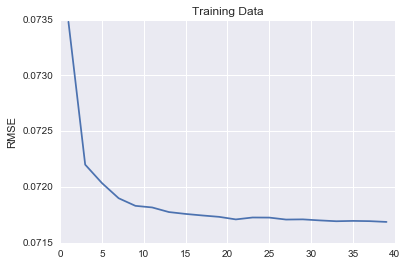

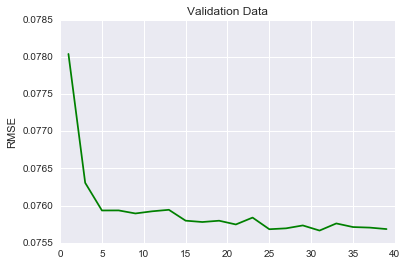

In [21]:
plt.plot(n_estimators, RF_train_results)
plt.ylabel("RMSE")
plt.title("Training Data")
plt.show()
plt.plot(n_estimators, RF_validate_results, c='g')
plt.ylabel("RMSE")
plt.title("Validation Data")

### Testing out k-fold validation

In [19]:
kf = KFold(50, 5, shuffle=True)

for train, test in kf:
    print(train, test)

[ 0  1  2  4  5  6  7 10 11 12 13 14 15 16 17 18 20 21 23 24 25 26 27 28 30
 31 32 34 35 36 37 38 39 40 41 42 43 44 45 49] [ 3  8  9 19 22 29 33 46 47 48]
[ 1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 18 19 20 21 22 23 25 27 29 30
 31 32 33 34 35 36 37 38 40 41 43 45 46 47 48] [ 0 10 17 24 26 28 39 42 44 49]
[ 0  1  3  5  8  9 10 11 14 15 16 17 18 19 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 38 39 40 41 42 43 44 46 47 48 49] [ 2  4  6  7 12 13 20 36 37 45]
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 17 18 19 20 22 24 26 27 28 29
 32 33 34 35 36 37 38 39 42 44 45 46 47 48 49] [11 16 21 23 25 30 31 40 41 43]
[ 0  2  3  4  6  7  8  9 10 11 12 13 16 17 19 20 21 22 23 24 25 26 28 29 30
 31 33 36 37 39 40 41 42 43 44 45 46 47 48 49] [ 1  5 14 15 18 27 32 34 35 38]


### Testing out PyBrain

In [41]:
from pybrain.datasets.supervised import SupervisedDataSet
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer

In [42]:
X_train.shape, np.array(Y_train).shape

((59933, 256), (59933,))

In [43]:
ds = SupervisedDataSet(X_train.shape[1], 1)
Y_train_neural = np.array(Y_train).reshape(-1, 1)
ds.setField('input', X_train)
ds.setField('target', Y_train_neural)

In [46]:
%%time
hidden_size = 100   # arbitrarily chosen

net = buildNetwork( X_train.shape[1], hidden_size, 1, bias = True )
trainer = BackpropTrainer( net, ds )

trainer.trainUntilConvergence( verbose = True, validationProportion = 0.15, maxEpochs = 100, continueEpochs = 10 )

KeyboardInterrupt: 

### sklearn Neural Network

In [28]:
from sknn.mlp import Regressor, Layer

Y_train_nn = np.array(Y_train)

nn = Regressor(
    layers=[
        Layer("Rectifier", units=100),
        Layer("Linear")],
    learning_rate=0.02,
    n_iter=10)
nn.fit(X_train, Y_train_nn)

INFO (theano.gof.compilelock): Refreshing lock /Users/ryankerr/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-2.7.11-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/ryankerr/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-2.7.11-64/lock_dir/lock


ImportError: ('The following error happened while compiling the node', Dot22(X, W), '\n', 'dlopen(/Users/ryankerr/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-2.7.11-64/tmp5nTyH1/eb163660e6e45b373cd7909e14efd44a.so, 2): Library not loaded: libmkl_intel_lp64.dylib\n  Referenced from: /Users/ryankerr/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-2.7.11-64/tmp5nTyH1/eb163660e6e45b373cd7909e14efd44a.so\n  Reason: image not found', '[Dot22(X, W)]')

In [30]:
print(np.distutils.__config__.show())

lapack_opt_info:
    libraries = ['mkl_lapack95_lp64', 'mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/Users/ryankerr/anaconda/envs/dev-sklearn/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ryankerr/anaconda/envs/dev-sklearn/include']
blas_opt_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/Users/ryankerr/anaconda/envs/dev-sklearn/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ryankerr/anaconda/envs/dev-sklearn/include']
openblas_lapack_info:
  NOT AVAILABLE
lapack_mkl_info:
    libraries = ['mkl_lapack95_lp64', 'mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/Users/ryankerr/anaconda/envs/dev-sklearn/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ryankerr/anaconda/envs/dev-skle